Контрольной (группе А) доступен первый вариант рекомендаций.
Тестовой (группе B) доступен второй вариант. 
Предполагается, что все условия и принципы проведения A/B-теста были соблюдены, то есть:

✔️ выборка имеет достаточный для принятия решения объём;

✔️ выбран достаточный интервал времени для тестирования;

✔️ группы максимально сбалансированы;

✔️ внешнее вмешательство минимально.

### <center> ЗНАКОМИМСЯ С ДАННЫМИ

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
ab_data = pd.read_csv('data/ab_data.csv')

In [3]:
ab_data.head()

,user_id,timestamp,group,converted
0,851104,2017-01-21,A,0
1,804228,2017-01-12,A,0
2,661590,2017-01-11,B,0
3,853541,2017-01-08,B,0
4,864975,2017-01-21,A,1


In [4]:
ab_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 290482 entries, 0 to 290481
Data columns (total 4 columns):
 #   Column     Non-Null Count   Dtype 
---  ------     --------------   ----- 
 0   user_id    290482 non-null  int64 
 1   timestamp  290482 non-null  object
 2   group      290482 non-null  object
 3   converted  290482 non-null  int64 
dtypes: int64(2), object(2)
memory usage: 8.9+ MB


Итак, в наших данных нет пропусков, однако нам нужно перевести столбец с информацией о дате события (timestamp) в формат datetime. Напомним: для этого мы можем воспользоваться функцией pandas to_datetime:

In [5]:
ab_data['timestamp'] = pd.to_datetime(ab_data['timestamp'], format='%Y-%m-%d')

В итоге мы получили таблицу, в которой отображены входы клиента на сайт (сессия) и его действия. Для того, чтобы получить показатель конверсии в группах на каждый день, нам необходимо предварительно сгруппировать наши данные по дате и группе и вычислить количество пользователей, заходивших на сайт, и суммарное количество совершённых целевых действий. 

Дополнительно для удобства сбросим индекс на сгруппированной таблице c помощью метода [reset_index()](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.reset_index.html) и переименуем столбец user_id в users_count с помощью метода [rename()](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.rename.html).

In [6]:
daily_data = ab_data.groupby(['timestamp','group']).agg({
    'user_id':'count',
    'converted':'sum'
}).reset_index().rename(columns={'user_id': 'users_count'})
daily_data.head()

,timestamp,group,users_count,converted
0,2017-01-02,A,2851,357
1,2017-01-02,B,2848,339
2,2017-01-03,A,6584,749
3,2017-01-03,B,6620,754
4,2017-01-04,A,6573,797


Для завершения этапа подготовки данных к анализу нам осталось рассчитать конверсию на каждый день проведения A/B-тестирования. Напомним: ежедневная конверсия рассчитывается как отношение числа посетителей сайта, выполнивших на нём какие-либо целевые действия в день, к ежедневному общему числу посетителей сайта, умноженная на 100 %:

In [7]:
daily_data['conversion'] = daily_data['converted']/daily_data['users_count'] * 100

In [8]:
display(daily_data.head())

,timestamp,group,users_count,converted,conversion
0,2017-01-02,A,2851,357,12.521922
1,2017-01-02,B,2848,339,11.903090
2,2017-01-03,A,6584,749,11.376063
3,2017-01-03,B,6620,754,11.389728
4,2017-01-04,A,6573,797,12.125361


### <center> ВИЗУАЛЬНЫЙ АНАЛИЗ КОНВЕРСИИ В ГРУППАХ

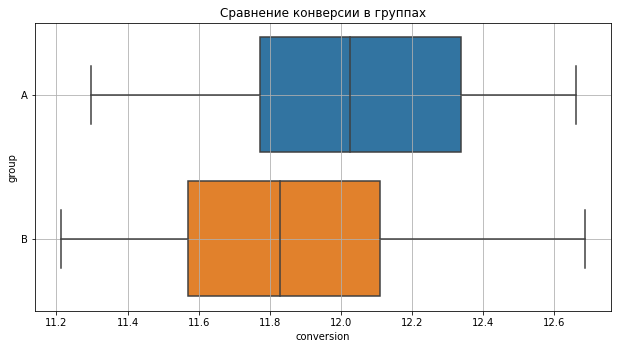

In [9]:
# создаём фигуру размером 8x4
fig = plt.figure(figsize=(8, 4)) 
# добавляем систему координат
ax = fig.add_axes([1, 1, 1, 1]) 
# строим boxplot для conversion по признаку group
sns.boxplot(data=daily_data, x='conversion', y='group', ax=ax) 
# задаём подпись к графику
ax.set_title('Сравнение конверсии в группах')
# задаём отображение сетки
ax.grid();

Что можно сказать исходя из этого графика? Во-первых, медианное значение ежедневной конверсии в группе А, выше, чем в группе B. Во-вторых, разброс конверсии в группе B несколько больше, чем в группе A.

Тут неопытный специалист воскликнет: версия рекомендаций А лучше, чем версия B (медиана конверсии варианта А больше, да и разброс поменьше, то есть конверсия более стабильна) — и завершит эксперимент. 

Но выводы делать ещё рано! И сейчас попробуем понять, почему. 

Давайте вычислим средний и медианный показатель конверсии в контрольной и тестовой группе и умножим результат на 100 (получим результат в процентах):

In [10]:
conversion_piv = daily_data.groupby('group')['conversion'].agg(
    ['mean', 'median']
)
display(conversion_piv)

,mean,median
group,,
A,12.032876,12.024261
B,11.872697,11.829582


Из полученной таблицы видно, что медиана и среднее в каждой группе практически совпадают. При этом разница между показателями в группах менее 0.3 %! 

Примечание. Вопрос о стабильности метрик является обязательным. Прогонять результаты через статистические тесты можно только после того, как вы убедитесь, что разница в ваших показателях стабилизировалась во времени. Это связано с проблемой подглядывания, речь о которой пойдёт ниже.

### <center> КУМУЛЯТИВНЫЕ МЕТРИКИ

**Кумулятивная метрика** — это отображение целевой метрики, когда вы отслеживаете её поведение за каждый день — накопленным итогом по дням. 

Так же и в A/B-тестировании(как с монеткой 100 раз или 10000 подкинуть): с самого начала любой из вариантов может показывать лучшие результаты, и статистическая значимость может быть достигнута уже в первые дни теста. Это явление называется **проблемой подглядывания**.

Важно! Не стоит торопиться: как минимум дождитесь накопления запланированных объёмов выборки и длительности теста. Но и тут не стоит заканчивать тест — проверьте, стабилизировались ли метрики!

Кумулятивный график конверсии может выглядеть, например, так: 

![alt](https://lms.skillfactory.ru/assets/courseware/v1/fde294a0331aca21aaa425f878fdfcd3/asset-v1:SkillFactory+DSPR-2.0+14JULY2021+type@asset+block/dst-eda-5-19.png)

Как видите, в начале данные подвержены сильному колебанию, но со временем они выравниваются.

Примечание. Кумулятивная метрика считается стабилизированной, когда на графике прекращаются резкие пики и спады показателя, и линия постепенно выравнивается в горизонтальную прямую.

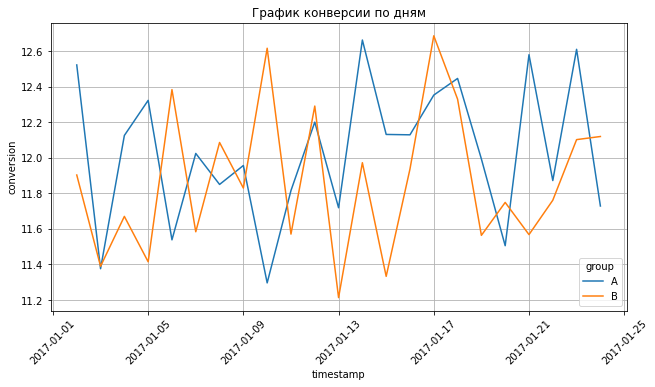

In [11]:
# создаём фигуру размером 8x4
fig = plt.figure(figsize=(8, 4))
# добавляем систему координат
ax = fig.add_axes([1, 1, 1, 1])
# строим lineplot для конверсии во времени в каждой группе
sns.lineplot(
    data=daily_data,
    x='timestamp',
    y='conversion',
    hue='group', 
    ax=ax
)
# задаём подпись к графику
ax.set_title('График конверсии по дням')
# задаём поворот меток на оси абсцисс
ax.xaxis.set_tick_params(rotation=45)
# задаём отображение сетки
ax.grid();

Что можно сказать по такому графику? Да практически ничего! Конверсия у обеих групп «скачет» день ото дня. Понять, какая из групп лучше, — практически невыполнимая задача. 

Именно поэтому и принято смотреть график кумулятивной конверсии, где за каждый день отображаются данные накопленным итогом.

Для расчёта кумулятивного показателя суммы в Pandas есть специальный метод [cumsum()](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.cumsum.html). Давайте посмотрим, как он работает — сначала на данных о ежедневном количестве посетителей для группы А. 

Выберем данные для группы А и создадим в полученной таблице новый столбец cum_users_count, в который запишем результат работы метода cumsum() по столбцу users_count:

In [12]:
# выделяем данные группы А
daily_data_a = daily_data[daily_data['group'] == 'A']
# считаем кумулятивное количество посетителей
daily_data_a.loc[:, 'cum_users_count'] = daily_data_a['users_count'].cumsum()
# выводим время, количество посетителей и кумулятивное количество посетителей
display(daily_data_a[['timestamp', 'users_count', 'cum_users_count']].head())

C:\Users\d3en\AppData\Local\Temp\ipykernel_14644\906787284.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  daily_data_a.loc[:, 'cum_users_count'] = daily_data_a['users_count'].cumsum()


,timestamp,users_count,cum_users_count
0,2017-01-02,2851,2851
2,2017-01-03,6584,9435
4,2017-01-04,6573,16008
6,2017-01-05,6419,22427
8,2017-01-06,6604,29031


То есть **кумулятивная сумма** — это накопительная сумма; каждое её значение — это результат сложения показателя за предыдущие дни с показателем за текущий день. 

S_{t}=S_{t-1}+x_{t}

x_{t} — значение показателя в день

S_{t} — значение суммы в день .

После этого рассчитаем **кумулятивную конверсию** — это отношение ежедневной кумулятивной суммы количества посетителей к ежедневной кумулятивной сумме количества совершённых целевых действий:

In [13]:
# вычисляем кумулятивную сумму количества посетителей
daily_data['cum_users_count'] = daily_data.groupby(['group'])['users_count'].cumsum()
# вычисляем кумулятивную сумму количества совершённых целевых действий
daily_data['cum_converted'] = daily_data.groupby(['group'])['converted'].cumsum()
# вычисляем кумулятивную конверсию
daily_data['cum_conversion'] = daily_data['cum_converted']/daily_data['cum_users_count'] * 100
display(daily_data.head())

,timestamp,group,users_count,converted,conversion,cum_users_count,cum_converted,cum_conversion
0,2017-01-02,A,2851,357,12.521922,2851,357,12.521922
1,2017-01-02,B,2848,339,11.903090,2848,339,11.903090
2,2017-01-03,A,6584,749,11.376063,9435,1106,11.722311
3,2017-01-03,B,6620,754,11.389728,9468,1093,11.544149
4,2017-01-04,A,6573,797,12.125361,16008,1903,11.887806


А теперь построим графики кумулятивной конверсии по дням в каждой группе:

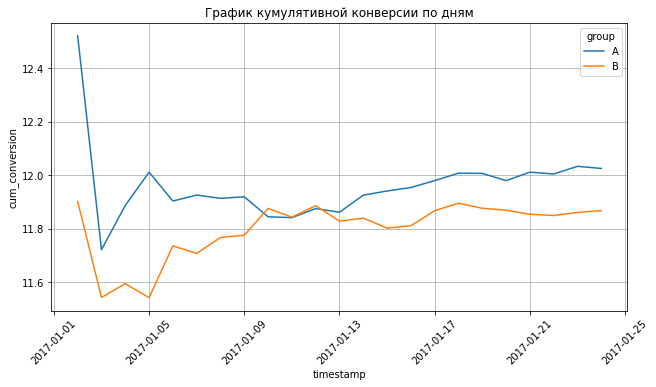

In [14]:
# создаём фигуру размером 8x4
fig = plt.figure(figsize=(8, 4))
# добавляем систему координат
ax = fig.add_axes([1, 1, 1, 1])
# строим lineplot для кумулятивной конверсии во времени в каждой группе
sns.lineplot(x='timestamp', y='cum_conversion', data=daily_data, hue='group', ax=ax)
# задаём подпись к графику
ax.set_title('График кумулятивной конверсии по дням')
# задаём поворот меток на оси абсцисс
ax.xaxis.set_tick_params(rotation = 45)
# задаём отображение сетки
ax.grid(True);

Обратите внимание на различие в конверсии в первые дни теста: тут наглядно отображена проблема подглядывания, когда статистическая значимость ошибочно могла быть достигнута уже в самом начале теста.

На основании стабилизированного кумулятивного графика мы можем сделать вывод, что длительность эксперимента была достаточной для того, чтобы судить о статистической значимости разности между показателем конверсии в группах.

### <center> ВВОДНЫЕ ДАННЫЕ ДЛЯ ЗАДАЧ 4.6–4.9

In [15]:
sample_a = pd.read_csv('data/ab_test-redesign_sample_a.csv')
sample_b = pd.read_csv('data/ab_test-redesign_sample_b.csv')

In [16]:
sample_a

,date,cid,transactions,revenue,group
0,2020-11-06,1.001648e+09,0,0,A
1,2020-11-06,1.001936e+09,0,0,A
2,2020-11-06,1.003214e+08,0,0,A
3,2020-11-06,1.004393e+09,0,0,A
4,2020-11-06,1.006382e+09,0,0,A
...,...,...,...,...,...
61566,2020-11-23,9.986289e+08,0,0,A
61567,2020-11-23,9.989196e+08,0,0,A
61568,2020-11-23,9.990631e+08,0,0,A
61569,2020-11-23,9.994210e+07,0,0,A


In [17]:
sample_a['date'] = pd.to_datetime(sample_a['date'], format='%Y-%m-%d')

In [18]:
sample_b['date'] = pd.to_datetime(sample_b['date'], format='%Y-%m-%d')

Постройте таблицу со следующими ежедневными показателями:

количество посетителей сайта;

суммарное число транзакций;

общая сумма покупок (выручка).

In [19]:
sample_a_sum = sample_a.groupby('date').agg({'cid': 'count', 'transactions':'sum','revenue': 'sum'})
sample_a_sum.head(3)

,cid,transactions,revenue
date,,,
2020-11-06,2576,16,1577279
2020-11-07,2704,23,1721886
2020-11-08,3354,25,846051


In [20]:
sample_b_sum = sample_b.groupby('date').agg({'cid': 'count', 'transactions':'sum','revenue': 'sum'})
sample_b_sum.head(3)

,cid,transactions,revenue
date,,,
2020-11-06,2499,19,996645
2020-11-07,2804,19,555499
2020-11-08,3291,24,3044842


Добавьте в каждую из таблиц кумулятивные метрики:

кумулятивное количество посетителей сайта;

кумулятивное суммарное число транзакций;

кумулятивная общая сумма покупок (кумулятивная выручка).

In [21]:
sample_a_sum['cum_cid'] = sample_a_sum['cid'].cumsum()
sample_a_sum['cum_transactions'] = sample_a_sum['transactions'].cumsum()
sample_a_sum['cum_revenue'] = sample_a_sum['revenue'].cumsum()

In [22]:
sample_b_sum['cum_cid'] = sample_b_sum['cid'].cumsum()
sample_b_sum['cum_transactions'] = sample_b_sum['transactions'].cumsum()
sample_b_sum['cum_revenue'] = sample_b_sum['revenue'].cumsum()


Рассчитайте кумулятивную конверсию действия покупки (в процентах) и кумулятивный средний чек (кумулятивная выручка/кумулятивное суммарное число транзакций).

In [23]:
sample_a_sum['cum_conversion'] = sample_a_sum['cum_transactions']/sample_a_sum['cum_cid']*100
sample_a_sum['cum_aver_check'] = sample_a_sum['cum_revenue']/sample_a_sum['cum_transactions']

In [24]:
sample_b_sum['cum_conversion'] = sample_b_sum['cum_transactions']/sample_b_sum['cum_cid']*100
sample_b_sum['cum_aver_check'] = sample_b_sum['cum_revenue']/sample_b_sum['cum_transactions']

Чему равна средняя кумулятивная конверсия в группах за весь период проведения A/B-теста? Ответ округлите до сотых, знаки процентов не вводите.

In [25]:
display(round(sample_a_sum['cum_conversion'].mean(), 2))
display(round(sample_b_sum['cum_conversion'].mean(), 2))

0.71

0.76

In [26]:
sample_a_sum.head(1)

,cid,transactions,revenue,cum_cid,cum_transactions,cum_revenue,cum_conversion,cum_aver_check
date,,,,,,,,
2020-11-06,2576,16,1577279,2576,16,1577279,0.621118,98579.9375


Постройте графики кумулятивной конверсии в каждой группе. Какие выводы по ним вы можете сделать?

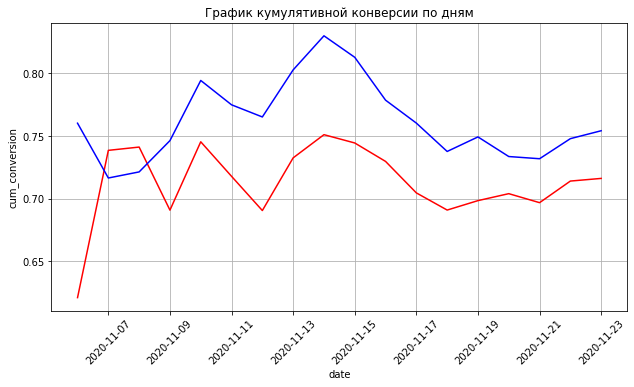

In [27]:
# создаём фигуру размером 8x4
fig = plt.figure(figsize=(8, 4))
# добавляем систему координат
ax = fig.add_axes([1, 1, 1, 1])
# строим lineplot для кумулятивной конверсии во времени в каждой группе
sns.lineplot(x='date', y='cum_conversion', data=sample_a_sum, ax=ax, color = 'red')
sns.lineplot(x='date', y='cum_conversion', data=sample_b_sum, ax=ax, color = 'blue')
# задаём подпись к графику
ax.set_title('График кумулятивной конверсии по дням')
# задаём поворот меток на оси абсцисс
ax.xaxis.set_tick_params(rotation = 45)
# задаём отображение сетки
ax.grid(True);

Постройте графики кумулятивного среднего чека в каждой группе. Какие выводы по ним вы можете сделать?

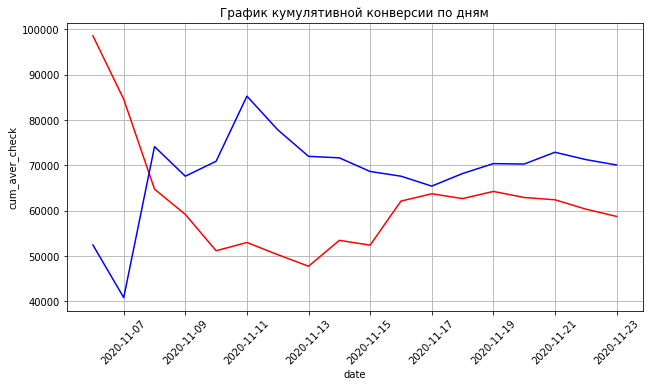

In [28]:
# создаём фигуру размером 8x4
fig = plt.figure(figsize=(8, 4))
# добавляем систему координат
ax = fig.add_axes([1, 1, 1, 1])
# строим lineplot для кумулятивной конверсии во времени в каждой группе
sns.lineplot(x='date', y='cum_aver_check', data=sample_a_sum, ax=ax, color = 'red')
sns.lineplot(x='date', y='cum_aver_check', data=sample_b_sum, ax=ax, color = 'blue')
# задаём подпись к графику
ax.set_title('График кумулятивной конверсии по дням')
# задаём поворот меток на оси абсцисс
ax.xaxis.set_tick_params(rotation = 45)
# задаём отображение сетки
ax.grid(True);

Проверьте гипотезу о нормальности распределений ежедневного среднего чека с помощью критерия Шапиро-Уилка. В качестве уровня значимости возьмите .

Каковы результаты тестирования?

In [30]:
from scipy.stats import shapiro
from scipy.stats import mannwhitneyu
# нулевая и альтернативная гипотезы
H0 = 'Распределения в обеих группах нормальные'
H1 = 'Распределение в одной или обеих группах отлично от нормального'
alpha = 0.1 # уровень значимости
# вычисляем результат теста Шапиро-Уилка для выборок
shapiro_result_a = shapiro(sample_a_sum['cum_aver_check'])
shapiro_result_b = shapiro(sample_b_sum['cum_aver_check'])
print('p-value группы А', round(shapiro_result_a.pvalue, 2))
print('p-value группы B', round(shapiro_result_b.pvalue, 2))
# сравниваем полученное p-value с уровнем значимости
if shapiro_result_a.pvalue < alpha or shapiro_result_b.pvalue < alpha:
    print("Отвергаем нулевую гипотезу. {}".format(H0))
    print("Альтернативная гипотеза. H1: {}".format(H1))
else:
    print("Принимаем нулевую гипотезу. {}".format(H0))
 
# p-value группы А 0.43
# p-value группы B 0.12
# Принимаем нулевую гипотезу. Распределения в обеих группах нормальные

p-value группы А 0.0
p-value группы B 0.0
Отвергаем нулевую гипотезу. Распределения в обеих группах нормальные
Альтернативная гипотеза. H1: Распределение в одной или обеих группах отлично от нормального


In [ ]:
from scipy.stats import mannwhitneyu

In [36]:
a = list(sample_a_sum['cum_aver_check'])
b = list(sample_b_sum['cum_aver_check'])
_, p = mannwhitneyu(a, b,  alternative='less', axis=0)
print(p)

0.0009153623248471153
